In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt
from sklearn import linear_model
import seaborn as sb


In [75]:
path = "./loan.csv"
inputDf = pd.read_csv(path, sep = ",", low_memory=False)

In [76]:
selectedCols = inputDf.copy(deep = True)

# Part One - Data Exploration

### parse data into numeric where relevant

In [77]:
termDummies = pd.get_dummies(selectedCols["term"]).drop(columns = [" 36 months"])
selectedCols = termDummies.join(selectedCols.drop(columns = ["term"]))
selectedCols.head()

,60 months,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000.0,5000.0,4975.0,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500.0,2500.0,2500.0,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1077175,1313524,2400.0,2400.0,2400.0,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1076863,1277178,10000.0,10000.0,10000.0,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1075358,1311748,3000.0,3000.0,3000.0,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
selectedCols["origYear"] = selectedCols["issue_d"].str.extract("\w{3}-(\d{4})")
selectedCols = selectedCols.drop(columns= ["issue_d"])

In [79]:
typedDf = selectedCols.copy(deep = True)

## look at distributions

In [80]:
# looking at data types
typedDf.dtypes

 60 months                       uint8
id                               int64
member_id                        int64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
earliest_cr_line         

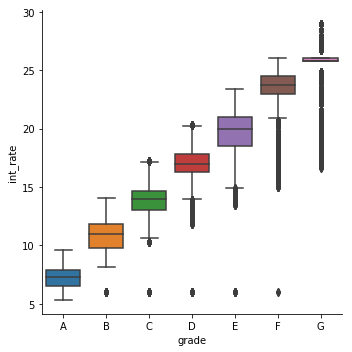

In [81]:
sb.catplot(x="grade", y="int_rate", data=typedDf, kind="box", order = ("A", "B", "C", "D", "E", "F","G"))
## worried that grades and interest rates lead to multicolinearity problems
## also notice that all grades except A and G have some sort of 'outlier' interest rate at 5%.

In [ ]:
# convert grades to numerics
gradeDummies = pd.get_dummies(selectedCols["grade"], prefix="grade")
selectedColsNoGrade = typedDf.drop(columns=["grade"])
dummiedGradesDf = gradeDummies.join(selectedColsNoGrade)

In [ ]:
dummiedGradesDf["grade"] = dummiedGradesDf["grade_A"] * 0 + \
    dummiedGradesDf["grade_B"] * 2 + dummiedGradesDf["grade_C"] * 3 + dummiedGradesDf["grade_D"] * 4  + \
    dummiedGradesDf["grade_E"] * 5 + dummiedGradesDf["grade_F"] * 6 + dummiedGradesDf["grade_G"] * 6
dummiedGradesDf = dummiedGradesDf.drop(columns=["grade_A", "grade_B", "grade_C", "grade_D", "grade_E", "grade_F", "grade_G"])

In [ ]:
typedDf = dummiedGradesDf

In [ ]:
import matplotlib.pyplot as plt
sb.jointplot(x="funded_amnt", y="int_rate", data = typedDf, kind="hex", height =8)

In [ ]:
#not surprising that annual income is highly skewed... lets bring this in a bit

In [ ]:
boxplot = typedDf.boxplot(column=['annual_inc'])

In [ ]:
incomeFilter = typedDf[typedDf["annual_inc"] < 300000]
sb.distplot(incomeFilter["annual_inc"].dropna())

In [ ]:
import matplotlib.pyplot as plt
sb.jointplot(x="funded_amnt", y="annual_inc", data = incomeFilter, kind="hex", height = 8)

### Look at Correlations

In [ ]:
sb.heatmap(typedDf.corr())

funded amt and loan amount are highly correlated

interest rate and grade highly correlated (as seen above in box/whisker)

### look at distributions

In [ ]:
### everything is skewed right, except grade which is perfectly balanced
### DTI seems to have an outlier, or is 9999 a null placeholder ?
normalized = typedDf.copy(deep = True)
normalized.describe()

In [ ]:
#looks like dti= 9999 is a null placeholder because there are few values between ~ 100 and that 9999 value
dti = typedDf[["dti"]]
boxplot = dti.boxplot(column=['dti'])

In [ ]:
#looks much better if we remove 9999 - still heavily skewed though.
boxplot = dti[dti["dti"] < 900 ].boxplot(column=['dti'])

In [ ]:
# much nicer if we remove outliers ( > 300)
boxplot = dti[dti["dti"] < 300].boxplot(column=['dti'])

In [ ]:
typedDf = typedDf[typedDf["dti"] < 300]

In [ ]:
def normalize(df, col):
    ser = df[[col]]
    normalized_ser=(ser-ser.min())/(ser.max()-ser.min())
    df.drop(columns=[col])
    df[col] = normalized_ser
    return df

In [ ]:
normalizeDf = typedDf.copy(deep = True)
normalize(normalizeDf, "loan_amnt")
normalize(normalizeDf, "funded_amnt")
normalize(normalizeDf, "int_rate")
normalize(normalizeDf, "annual_inc")
normalize(normalizeDf, "dti")
normalize(normalizeDf, "revol_bal")
normalize(normalizeDf, "total_pymnt")
normalize(normalizeDf, "grade")
normalizeDf.boxplot(column=["loan_amnt", "funded_amnt", "int_rate", "annual_inc",
                                  "dti", "revol_bal", "total_pymnt", "grade"], figsize=(13,6))

In [ ]:
#Confirms suspicions of bad skew.
# annual income being the worst offender. nothing to do now other than just keep note for later stages
typedDf.skew(axis = 0)

In [ ]:
hist = typedDf[" 60 months"].hist(bins=2)
## most loans are 36 month

In [ ]:
typedDf["revol_bal"] = pd.cut(typedDf["revol_bal"], bins = [-2, 20000, 300000, 5000000], labels = ["low", "medium", "high"])
sb.catplot(x="revol_bal", kind="count", data=typedDf)


In [ ]:
#sb.distplot(revolvingBals.dropna(), )
#sb.catplot(revolvingBals, kind="count", palette="ch:.25");
revolvingBals.hist()

# Part Two - Business Analysis
#### footnote - this did not say to balance weight, but this should be balance weighted

In [ ]:
##only look at 36 month loans
shortTerm = typedDf[typedDf[" 36 months"] == 1]


In [ ]:
shortTerm.loan_status.value_counts()

In [ ]:
## only look at loans that are no longer alive 
# assuming that if they are done paying they are in one of three categories below
# not sure what: "Does not meet the credit policy. Status:Charged Off", "Does not meet the credit policy. Status:Charged Off"
shortTerm = shortTerm[(shortTerm["loan_status"] == "Fully Paid") | (shortTerm["loan_status"] == "Charged Off") | 
                    (shortTerm["loan_status"] == "Default")]

#### Pct loans fully paid ?

In [ ]:
statuses = shortTerm["loan_status"].value_counts()
counts = statuses
relFreqs = statuses /shortTerm.size
fullyPaidIndex = 1
print("there are {} loans fully paid, which represents {} loans".format(counts[fullyPaidIndex], relFreqs[fullyPaidIndex]))

#### highest rates of default ? 

In [ ]:
defaultDf = shortTerm[["origYear", "grade", "loan_status"]]

In [ ]:
statusDummies = pd.get_dummies(defaultDf["loan_status"])
defaultDf["defaulted"] = (statusDummies[["Fully Paid"]] * - 1) + 1

In [ ]:
defaultGroupings = defaultDf.groupby(['origYear', 'grade']).mean()
cohorts = defaultGroupings.sort_values(by = "defaulted", ascending = False)
#defaultGroupings.unstack()
maxDefaults = cohorts.iloc[:1,]
print(maxDefaults)
print("the highest default rate of 0.5 was found among 2008 G's !")

### annualized rate of return

In [ ]:
rateReturn = shortTerm

In [ ]:
rateReturn["annualizedRateReturn"] = np.power((rateReturn["total_pymnt"] / rateReturn["funded_amnt"]), 1/3) - 1

In [ ]:
rateReturn = rateReturn[["annualizedRateReturn", "origYear", "grade"]]

In [ ]:
rateReturn.head()

In [ ]:
returnCohorts = rateReturn.groupby(['origYear', 'grade']).mean()
returnCohorts = returnCohorts.sort_values(by = "annualizedRateReturn", ascending = False)

#### below is a summary of the annualized rate of return for each cohort (grouped by origination year and grade)

In [ ]:
rateReturn.groupby(['origYear', 'grade']).mean().unstack()

# Part 3 - Modeling

In [ ]:
modelDf = typedDf.copy(deep = True)
modelDf.head()

let's get rid of outliers we detected in part 1

In [ ]:
modelDf = modelDf[modelDf["dti"] < 300]

In [ ]:
modelDf = modelDf[modelDf["annual_inc"] < 300000]

In [ ]:
modelDf = modelDf[(modelDf["loan_status"] == "Fully Paid") |
                                          (modelDf["loan_status"] == "Charged Off") |
                                          (modelDf["loan_status"] == "Default")]
statusDummies = pd.get_dummies(modelDf["loan_status"])
modelDf["defaulted"] = (statusDummies[["Fully Paid"]] * - 1) + 1

### first pass using the variables used in data analysis thus far

In [ ]:
firstPassRegression = modelDf[["loan_amnt", " 60 months", "int_rate", "annual_inc", 
         "dti", "revol_bal", "total_pymnt", "loan_status"]]

### create features / labels

In [ ]:
firstPassRegression = firstPassRegression[(firstPassRegression["loan_status"] == "Fully Paid") |
                                          (firstPassRegression["loan_status"] == "Charged Off") |
                                          (firstPassRegression["loan_status"] == "Default")]
statusDummies = pd.get_dummies(firstPassRegression["loan_status"])
firstPassRegression["defaulted"] = (statusDummies[["Fully Paid"]] * - 1) + 1

In [ ]:
labels = firstPassRegression["defaulted"]
features = firstPassRegression.drop(columns=["defaulted", "loan_status"])

### split train and test

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

### Establish Baseline

In [ ]:
from sklearn.dummy import DummyClassifier
freqentist = DummyClassifier(strategy='most_frequent')
freqentist.fit(train_features, train_labels)
print("baseline prediction accuracy is {}".format(freqentist.score(test_features, test_labels).round(4)))

### Try multivariate linear regression

In [ ]:
ols = linear_model.LinearRegression(normalize = False)
model = ols.fit(train_features, train_labels)

In [ ]:
print("OLS regression has an R^2 of {} in sample".format(model.score(train_features, train_labels).round(4)))
print("OLS regression has an R^2 of {} out of sample".format(model.score(test_features, test_labels).round(4)))


####  lets work harder on variable selection

In [ ]:
varSelection = inputDf[["application_type", "collections_12_mths_ex_med", "earliest_cr_line", "emp_length",
         "funded_amnt", "grade", "home_ownership", "installment", "int_rate",
         "mths_since_last_delinq", "pub_rec", "revol_util", "total_acc",
         "acc_now_delinq", "recoveries", "loan_status", "last_pymnt_amnt", "last_pymnt_d"]]

In [ ]:
varSelection.head()

In [ ]:
applicationDummies = pd.get_dummies(varSelection[["application_type", "home_ownership"]])
varSelection = varSelection.drop(columns = ["application_type", "home_ownership"])
applicationDummies = applicationDummies.drop(columns = ["application_type_INDIVIDUAL"])
varSelection = applicationDummies.join(varSelection)

In [ ]:
varSelection["earliest_cr_line"] = varSelection["earliest_cr_line"].str.extract("\w{3}-(\d{4})")
varSelection["last_pymnt_d"] = varSelection["last_pymnt_d"].str.extract("\w{3}-(\d{4})")
varSelection["emp_length"] = varSelection["emp_length"].str.extract("(\d+).*")

In [ ]:
varSelection = varSelection.dropna()

In [ ]:
labels = varSelection["defaulted"]
features = varSelection.drop(columns=["defaulted", "loan_status"])

In [ ]:
#take 5 strongest variables
from sklearn.feature_selection import chi2
X_new = SelectKBest(chi2, k="all").fit_transform(features, labels)
features = X_new

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
ols = linear_model.LinearRegression(normalize = False)
model = ols.fit(train_features, train_labels)

In [ ]:
print("OLS regression has an R^2 of {} in sample".format(model.score(train_features, train_labels).round(4)))
print("OLS regression has an R^2 of {} out of sample".format(model.score(test_features, test_labels).round(4)))

In [ ]:
from sklearn.linear_model import Lasso

from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
res = clf.fit(train_features, train_labels)
res.score(test_features, test_labels)

In [ ]:
from sklearn.feature_selection import SelectKBest

from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_regression

In [ ]:
SelectKBest(f_regression).fit_transform(train_features, train_labels)

In [ ]:
f_regression(train_features, train_labels)

In [ ]:
selector = SelectPercentile(f_regression, percentile=10)
selector.fit(train_features, train_labels)
scores = -np.log10(selector.pvalues_)

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

est = sm.OLS(train_labels, train_features)
result = est.fit()

print(result.summary())